In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.axes_size import Fixed, Scaled
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.visualization.wcsaxes import SphericalCircle
import numpy as np
from astropy.io import fits
import os
from astropy.io import ascii
import extinction
pgf_with_latex = { 
    "ytick.right":  True, # 
    "xtick.top":  True, # 
    "xtick.direction":  "in", # direction: {in, out, inout}
    "ytick.direction":  "in", # direction: {in, out, inout}
    "xtick.minor.visible": True,   # visibility of minor ticks on x-axis
    "ytick.minor.visible": True,   # visibility of minor ticks on y-axis
     "xtick.labelsize":15, 
     "ytick.labelsize":15,
     "xtick.major.size": 5,       # major tick size in points
     "ytick.major.size": 5,       # major tick size in points
     "xtick.minor.size": 2.5,     # major tick size in points
     "ytick.minor.size": 2.5,     # major tick size in points
     "xtick.major.width":   0.9,  # major tick width in points
     "ytick.major.width":   0.9,  # major tick width in points
     "figure.dpi":         300, 
     "font.size":         20, 
     "savefig.transparent": False,
#    "axes.labelsize": 30,
    # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],              # LaTeX default is 10pt font.            # Make the legend/label fonts a little smaller
    "pgf.preamble": r"\usepackage[ut f8x]{inputenc} \usepackage[T1]{fontenc}"   

}
mpl.rcParams.update(pgf_with_latex)



In [2]:
# step 1: The photometry in Vega magnitudes can be converted to units of either F_λ or F_ν.

# For F_ν, using the common AB magnitude system, then a source with a measured magnitude of zero
# in any band by definition has a reference flux of 3631 Jy, ie F0 is always 3631 Jy
# m_AB=-2.5*log10(F)+c
# c=0+2.5*log10(3631)
# c = -8.90006562228

# For Flux in units of Jy, and magnitude in units of mag
# F_ν(Jy)=10(23-(m_AB+48.6)/2.5)
# m_AB=-2.5*((23-log10(F_ν))-48.6)

# m_AB=-2.5*log_10(F_ν)+8.90
# (8.90-m_AB)/2.5=log_10(F_ν)
# F_ν=10^((8.90-m_AB)/2.5)

# for F_λ you can look up the flux of zero magnitude (F0) from: http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse&gname=PAN-STARRS&asttype=

# F_ν = F_λ*(lambda^2/c) 
# F_λ (erg/cm^2/sec/Angstrom) = F_ν (Jy)/(3.33564*10^(4)*(lambda(A)^2))


# e.g. http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse&gname=HST&asttype=
# zeropoints from here



In [3]:
eff_wavelength={'WFC3_IR/F110W':11534.46, #Angstrom 
                'WFC3_IR/F128N':12836.65, 
                'WFC3_IR/F160W':15370.34,
                'WFC3_UVIS1/F218W':2225.17,
                'WFC3_UVIS1/F475W':4773.10,
                'WFC3_UVIS1/F555W':5308.42,
                'WFC3_UVIS1/F625W':6242.56,
                'WFC3_UVIS1/F814W':8039.03,
                'WFPC2-WF/F218W':2203.41,
                'WFPC2-WF/F300W':2984.47,
                'WFPC2-WF/F336W':3344.09,
                'WFPC2-WF/F439W':4311.49,
                'WFPC2-WF/F547M':5483.76,
                'WFPC2-WF/F555W':5442.21,
                'WFPC2-WF/F814W':8001.59,
                'ACS_WFC/F658N':6583.95,
                'ACS_WFC/F814W':8045.53}

print(eff_wavelength)

{'WFC3_IR/F110W': 11534.46, 'WFC3_IR/F128N': 12836.65, 'WFC3_IR/F160W': 15370.34, 'WFC3_UVIS1/F218W': 2225.17, 'WFC3_UVIS1/F475W': 4773.1, 'WFC3_UVIS1/F555W': 5308.42, 'WFC3_UVIS1/F625W': 6242.56, 'WFC3_UVIS1/F814W': 8039.03, 'WFPC2-WF/F218W': 2203.41, 'WFPC2-WF/F300W': 2984.47, 'WFPC2-WF/F336W': 3344.09, 'WFPC2-WF/F439W': 4311.49, 'WFPC2-WF/F547M': 5483.76, 'WFPC2-WF/F555W': 5442.21, 'WFPC2-WF/F814W': 8001.59, 'ACS_WFC/F658N': 6583.95, 'ACS_WFC/F814W': 8045.53}


In [4]:
#make dictionary of all the extinction values for all filters (like eff_wavelength but extinction values in magnitude)
#extinction.fm07(values at eff_wavelength, a_v=3.1 * mwebv, unit='aa')
#Landolt B - Landolt V
#https://ned.ipac.caltech.edu/extinction_calculator
mwebv=1.348-1.020

#convert eff_wavelength to array
count = 0
eff_wavelength_arr = np.zeros(len(eff_wavelength))
for i in eff_wavelength:
    #print(float(eff_wavelength[i]))
    eff_wavelength_arr[count] = float(eff_wavelength[i])
    count += 1


#print(eff_wavelength_arr)
#apply extinction of fm07
extinction_values = extinction.fm07(eff_wavelength_arr, a_v=3.1 *mwebv, unit ='aa')
#print(extinction_values)
extinction_values_dic = eff_wavelength
#apply those values back to the dictionary
count = 0
for i in eff_wavelength:
    update_value = extinction_values[count]
    extinction_values_dic.update({i:update_value})
    count += 1
#dictionary of filters and extinction value at each array
print(extinction_values_dic)

{'WFC3_IR/F110W': 0.2829654868702418, 'WFC3_IR/F128N': 0.23256331474215036, 'WFC3_IR/F160W': 0.16724301305577416, 'WFC3_UVIS1/F218W': 3.252109205635757, 'WFC3_UVIS1/F475W': 1.2215296228768513, 'WFC3_UVIS1/F555W': 1.0740967005995978, 'WFC3_UVIS1/F625W': 0.8496815594471789, 'WFC3_UVIS1/F814W': 0.5514034020317718, 'WFPC2-WF/F218W': 3.2992002998714383, 'WFPC2-WF/F300W': 1.8845733749146114, 'WFPC2-WF/F336W': 1.6705108462342633, 'WFPC2-WF/F439W': 1.3570766095990843, 'WFPC2-WF/F547M': 1.0285701931054372, 'WFPC2-WF/F555W': 1.0392307025688365, 'WFPC2-WF/F814W': 0.5560848840692143, 'ACS_WFC/F658N': 0.7799596488677424, 'ACS_WFC/F814W': 0.5505961931476128}


In [5]:
# Dolphot output is in Vega
#put in vega,err
dolphot_mag = {'WFC3_UVIS1/F555W':[26.214,0.128],
               'WFC3_UVIS1/F814W':[24.24,0.078]} 

#Landolt B - Landolt V
#https://ned.ipac.caltech.edu/extinction_calculator
mwebv=1.348-1.020

filters = list(dolphot_mag.keys())
print(dolphot_mag)

def vega_mag_2_fλ_abmag(d):
    d2=d
    # vega mag to fλ in units erg/cm^2/s/A 
    zp_fλ={'WFC3_IR/F110W':4.00095e-10,
        'WFC3_IR/F128N':2.48561e-10,
        'WFC3_IR/F160W':1.42481e-10,
        'WFC3_UVIS1/F218W':4.72852e-9,
        'WFC3_UVIS1/F475W':5.26539e-9,
        'WFC3_UVIS1/F555W':3.96448e-9,
        'WFC3_UVIS1/F625W':2.43023e-9,
        'WFC3_UVIS1/F814W':1.13481e-9,
        'WFPC2-WF/F218W':4.81765e-9,
        'WFPC2-WF/F300W':3.61563e-9,
        'WFPC2-WF/F336W':3.32587e-9,
        'WFPC2-WF/F439W':6.77692e-9,
        'WFPC2-WF/F547M':3.60737e-9,
        'WFPC2-WF/F555W':3.68818e-9,
        'WFPC2-WF/F814W':1.14897e-9,
        'ACS_WFC/F658N':1.78447e-9,
        'ACS_WFC/F814W':1.1304e-9}
        #fλ in units erg/cm^2/s/A converts to AB magnitude
    zp_ab={'WFC3_IR/F110W':8.18187e-10,
                 'WFC3_IR/F128N':6.60607e-10,
                 'WFC3_IR/F160W':4.60766e-10,
                 'WFC3_UVIS1/F218W':2.19848e-8,
                 'WFC3_UVIS1/F475W':4.778e-9,
                 'WFC3_UVIS1/F555W':3.86293e-9,
                 'WFC3_UVIS1/F625W':2.79332e-9,
                 'WFC3_UVIS1/F814W':1.68438e-9,
                 'WFPC2-WF/F218W':4.81765e-9,
                 'WFPC2-WF/F300W':1.22212e-8,
                 'WFPC2-WF/F336W':9.73396e-9,
                 'WFPC2-WF/F439W':5.85587e-9,
                 'WFPC2-WF/F547M':3.61984e-9,
                 'WFPC2-WF/F555W':3.67533e-9,
                 'WFPC2-WF/F814W':1.70018e-9,
                 'ACS_WFC/F658N':2.51115e-9,
                 'ACS_WFC/F814W':1.68166e-9}
    #make flux array
    flux_arr = np.zeros(len(dolphot_mag))#make flux arr, extinction.remove only takes array
    extinction_values_current = np.zeros(len(dolphot_mag))#make extinction value array of only what we need
    mag_ab_arr = np.zeros(len(dolphot_mag))#make mag arr to apply extinction
    
    count = 0
    for key in d:
        flux=zp_fλ[key]*np.power(10,(d[key][0])/-2.5)
        flux_arr[count] = flux #add to flux array
        flux_unc=flux-zp_fλ[key]*np.power(10,(d[key][0]+d[key][1])/-2.5)
        mag_ab=-2.5*np.log10(flux/zp_ab[key])
        mag_ab_arr[count] = mag_ab
        #print(-2.5*np.log10((flux-flux_unc)/zp_ab[key]))
        mag_ab_unc=-2.5*np.log10((flux-flux_unc)/zp_ab[key])-mag_ab
        d2[key].append("{:.4e}".format(flux))
        d2[key].append("{:.4e}".format(flux_unc))
        d2[key].append("{:.2f}".format(mag_ab))
        d2[key].append("{:.2f}".format(mag_ab_unc))
        count += 1
        
    #extinction correction
    count = 0
    for key in d:#append correct flux
        extinction_values_current[count] = extinction_values_dic[key] #add extinction values needed from filters
        mag_ab_arr[count] = mag_ab_arr[count] - extinction_values_dic[key]
        count += 1
        
    flux_corrected = extinction.remove(extinction_values_current, flux_arr)#correct flux
    #print(flux_arr)
    #print(extinction_values_current)
    #print(flux_corrected)
    
    #apply extinction correction
    count = 0
    for key in d:#append correct flux
        d2[key].append(flux_corrected[count])
        d2[key].append(mag_ab_arr[count])
        count += 1
    
    return(d2)

#take values of vega/mag_ab from dict_mag and subtract extinction_values

dict_mag=vega_mag_2_fλ_abmag(dolphot_mag)
print(dict_mag)


{'WFC3_UVIS1/F555W': [26.214, 0.128], 'WFC3_UVIS1/F814W': [24.24, 0.078]}
{'WFC3_UVIS1/F555W': [26.214, 0.128, '1.2959e-19', '1.4412e-20', '26.19', '0.13', 3.485177579453686e-19, 25.111729817195705], 'WFC3_UVIS1/F814W': [24.24, 0.078, '2.2852e-19', '1.5841e-20', '24.67', '0.08', 3.7973839893601306e-19, 24.117388902684084]}


In [6]:
# step 2  - Apply Galactic extinction correction

# E(B-V) = 0.420
# R_V = 3.1$;  changes the shape of the extinction curve, rather than just the amplitude. A_V is linear scaling
# Cardelli, Clayton & Mathis (1989) R_V = 3.1
# R_V=A_V/E(B-V), where E(B-V) is the difference in extinction between the B and V bands 
# A_V = R_V * E(B-V) = 3.1 * 0.420 = 1.302
# "deredden" flux by 1.302
#dereddened_flux=remove(ccm89(wave, 1.302, 3.1), flux_p)
#extinction.fitzpatrick99(wave, 1.0, 3.1)

In [7]:
def createpickledic(path):
    pickle_dic = {}
    dir_list = os.listdir(path)
    #for each file in path
    for file in os.listdir(path):
        img = fits.open(path+file)
        data, header = fits.getdata(path+file, header = True)
        pickle_dic.update({file: [data , header]})  
    return pickle_dic

path = '/Users/Dominic/Downloads/Lamat-progenitor-project-main 6/dat_uvk/'
pickle_dic = createpickledic(path)


In [8]:
# extinction correction

def createfilterdic(path):
    filter_dic = {}
    dir_list = os.listdir(path)
    #for each file in path
    for file in os.listdir(path):
        data = ascii.read(path+file)
        split=file.split(".")
        filt_name="/"+split[1]
        inst_name=split[0].split("HST_")[1]
        #print(inst_name+filt_name)
        #ACS-WFC/F814W
        #img = fits.open(path+file)
        #data, header = fits.getdata(path+file, header = True)
        filter_dic.update({inst_name+filt_name: [data]})  
    return filter_dic

path = '/Users/Dominic/Downloads/Lamat-progenitor-project-main 6/filter_profiles/'
filter_dic = createfilterdic(path)
print(filter_dic)




{'WFPC2-WF/F336W': [<Table length=418>
  col1      col2   
float64   float64  
------- -----------
 2920.0 1.27423e-05
 2930.0 4.71919e-05
 2940.0 0.000130297
 2942.0 0.000106875
 2944.0 0.000125185
 2946.0 0.000151199
    ...         ...
 3830.0 0.000138077
 3840.0 9.97847e-05
 3850.0 6.65366e-05
 3860.0 4.52802e-05
 3870.0 2.79786e-05
 3880.0 1.76238e-05
 3890.0 9.91171e-06], 'WFPC2-WF/F300W': [<Table length=187>
  col1      col2   
float64   float64  
------- -----------
 2280.0 5.84065e-06
 2290.0 1.25171e-05
 2296.0 2.12065e-05
 2300.0 2.71663e-05
 2310.0 5.05946e-05
 2320.0 9.44587e-05
    ...         ...
 4060.0 2.25743e-05
 4070.0 1.71608e-05
 4080.0 1.35118e-05
 4090.0 1.02919e-05
 4100.0 8.10557e-06
 4110.0 6.22466e-06
 4120.0 4.89055e-06], 'WFPC2-WF/F814W': [<Table length=1526>
  col1      col2   
float64   float64  
------- -----------
 6830.0 2.43549e-05
 6840.0 3.79567e-05
 6850.0 5.53465e-05
 6860.0 8.49752e-05
 6870.0 0.000121737
 6880.0 0.000182322
    ...         ...


In [9]:
#https://adsabs.harvard.edu/full/1996BaltA...5..459S first equation (make fnunction of it) scipy.integrate.simpson
#col1 is wavelength in angstrom column2 is transmission
filter_dic['WFC3_UVIS1/F814W']
filter_dic['WFC3_UVIS1/F555W']
#compare model magnitudes of our own corrected extincted magnitude

[<Table length=3686>
     col1        col2   
   float64     float64  
 ----------- -----------
      4323.0 5.98122e-05
      4324.0 6.57137e-05
      4325.0 7.16168e-05
      4326.0 7.75216e-05
      4327.0  8.3435e-05
      4328.0 8.93434e-05
         ...         ...
      7669.0 5.92862e-05
      7670.0 5.89653e-05
      7671.0   5.865e-05
      7672.0 5.83349e-05
 7672.111328 5.82993e-05
      7673.0 5.79605e-05
      7674.0 5.75848e-05]

In [10]:
# Fit the pickles library! 
# https://archive.stsci.edu/hlsps/reference-atlases/cdbs/grid/pickles/AA_README
# https://ui.adsabs.harvard.edu/abs/1998PASP..110..863P/abstract

def createpickledic(path):
    pickle_dic = {}
    dir_list = os.listdir(path)
    #for each file in path
    for file in os.listdir(path):
        img = fits.open(path+file)
        data, header = fits.getdata(path+file, header = True)
        pickle_dic.update({file: [data , header]})  
    return pickle_dic

path = '/Users/Dominic/Downloads/Lamat-progenitor-project-main 6/dat_uvk/'
pickle_dic = createpickledic(path)


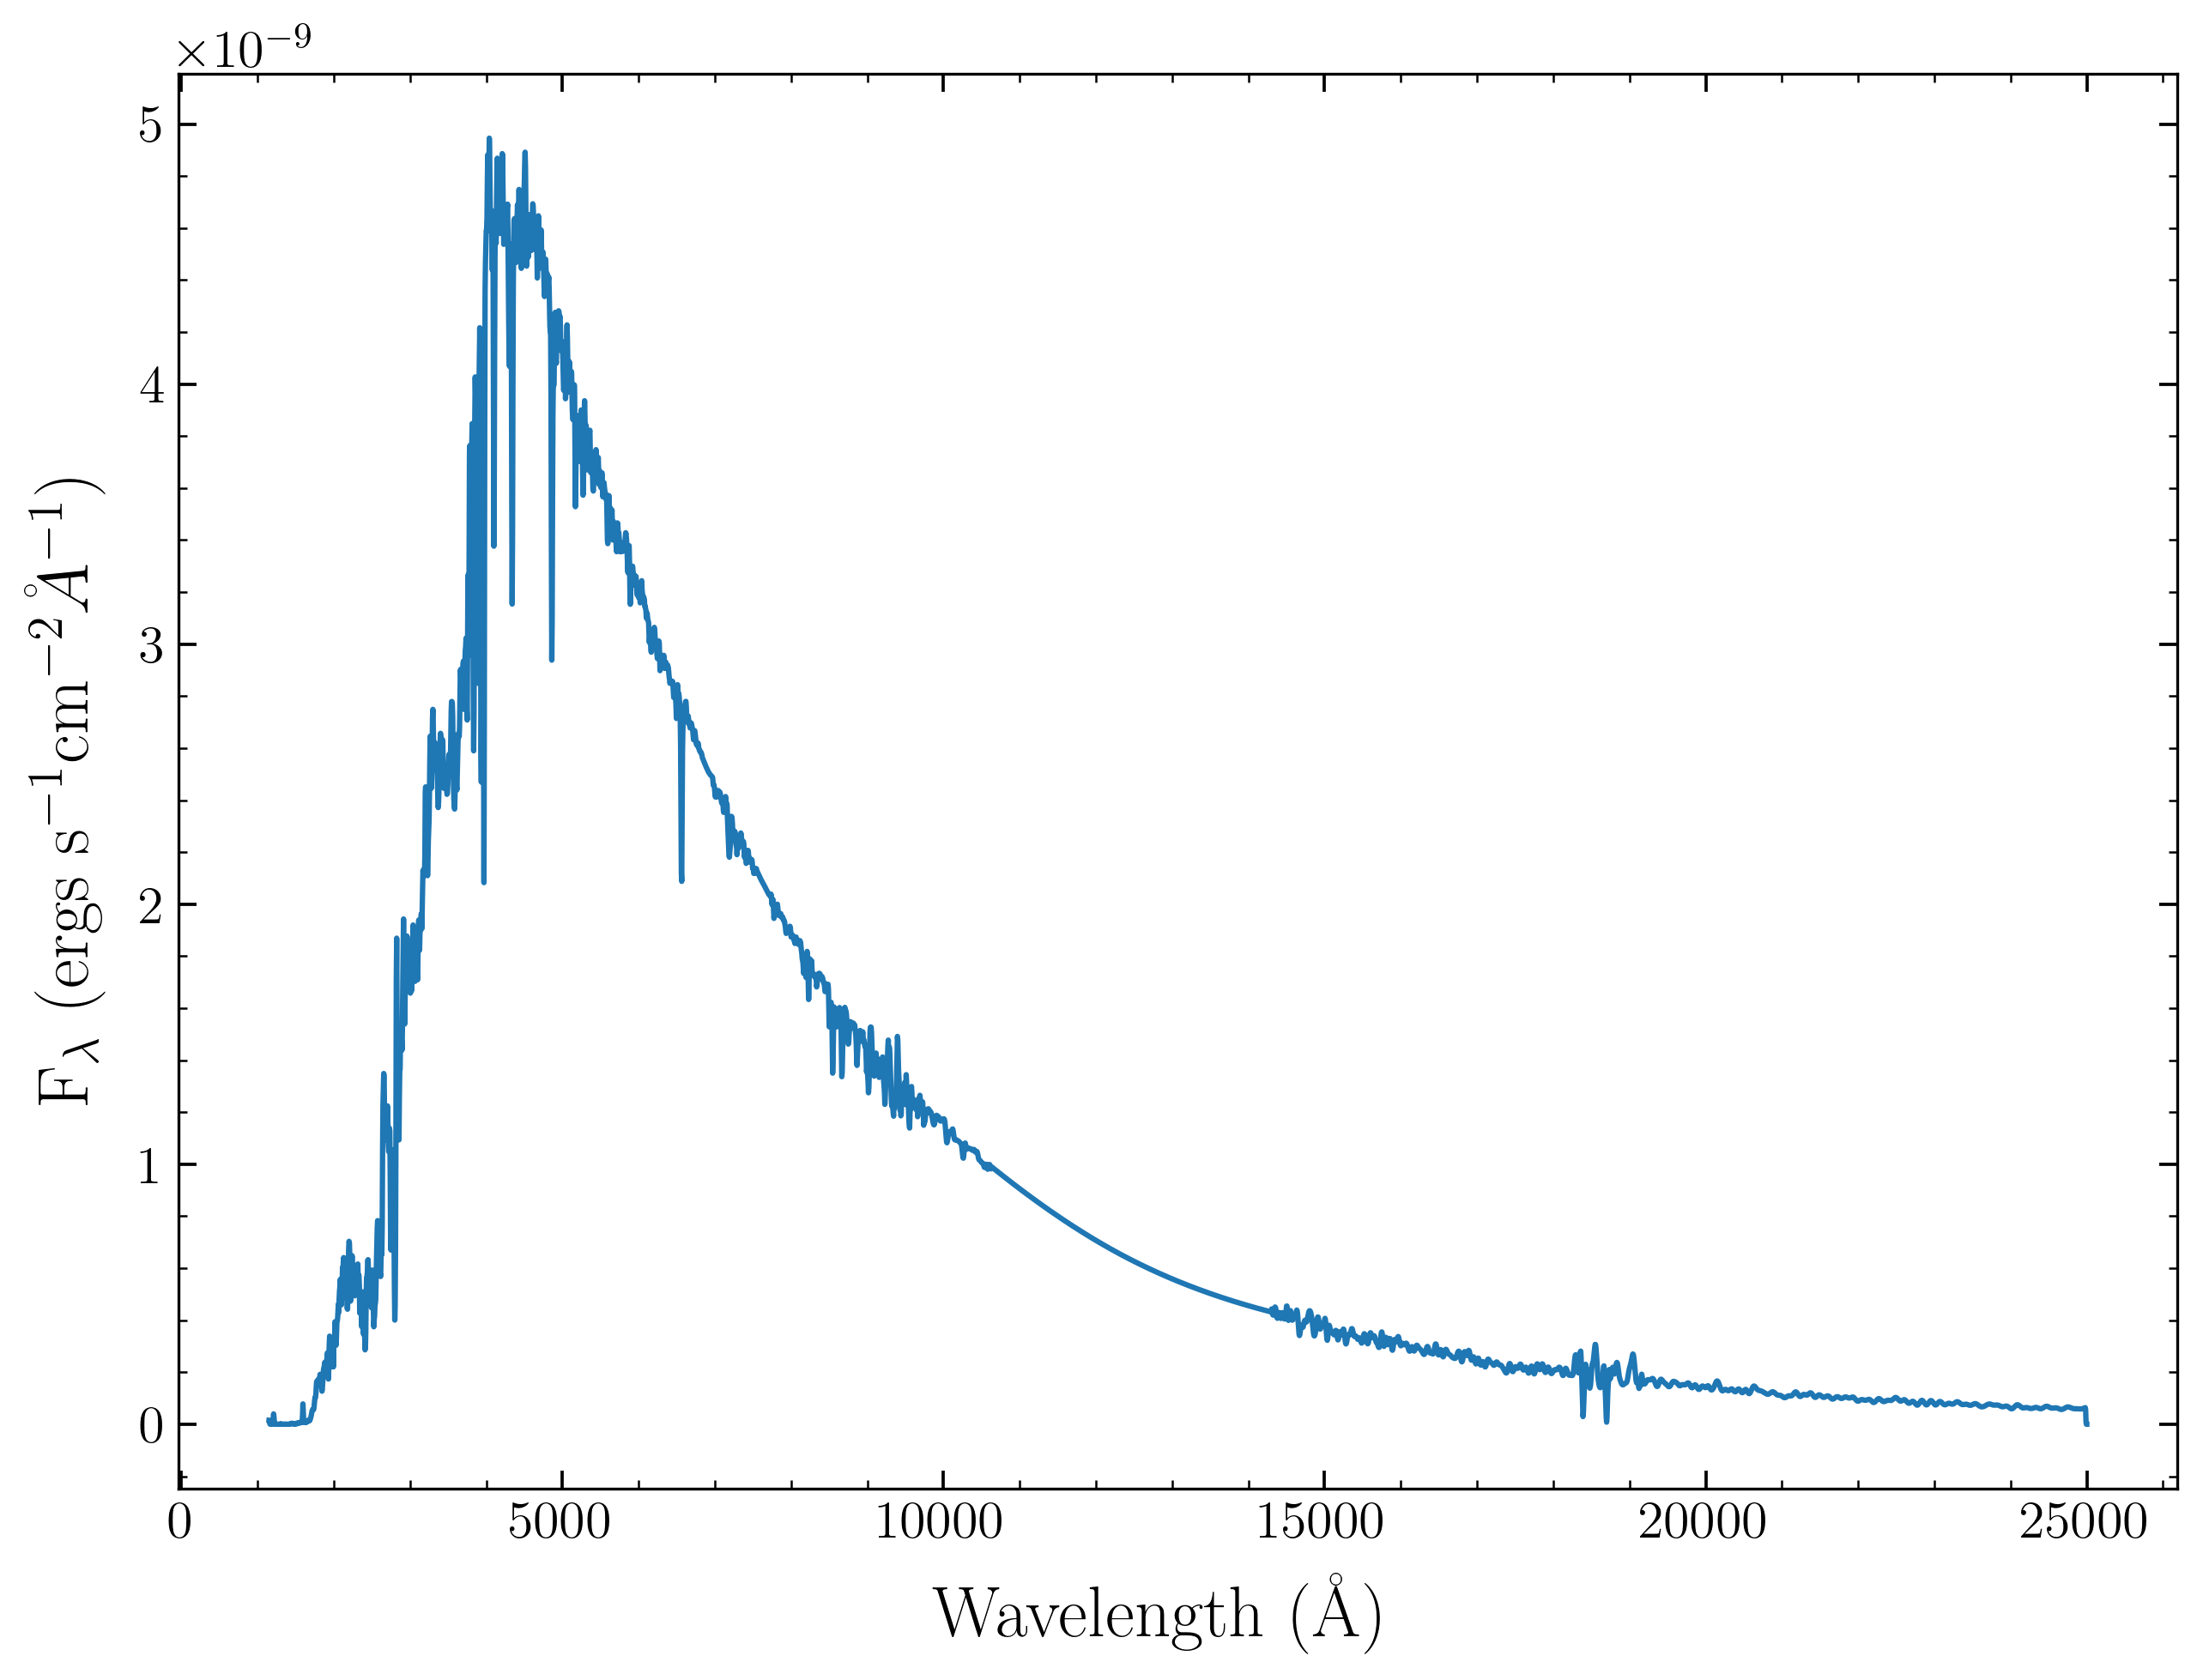

In [11]:
fig = plt.figure(constrained_layout=True,figsize=(8,6),facecolor='white')
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])

# example data
x = np.arange(0.1, 4, 0.5)
y = np.exp(-x)
error = 0.1 + 0.2 * x
lower_error = 0.4 * error
upper_error = error

ax1.plot(pickle_dic['pickles_uk_51.fits'][0]['WAVELENGTH'],pickle_dic['pickles_uk_51.fits'][0]['FLUX'])

asymmetric_error = [lower_error, upper_error]

#ax1.errorbar(x, y*1e-9, yerr=asymmetric_error, fmt='o')

fig.text(0.5, -0.05, r'Wavelength (\AA)', ha='center')
fig.text(-0.05, 0.5, r'F$_\lambda$ (ergs s$^{-1}$cm$^{-2}\AA^{-1}$)', va='center', rotation='vertical')

plt.savefig('2021sjt_SED_plot.png',bbox_inches='tight')